In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid')

## Brainstorming
- Bigger weights for `amount_borrowed`, `borrowed_in_months`, `n_bankruptcies`
- Filling NaN of `ok_since` with 0? Expect the worst?
- If the person does not have Facebook, it is for a reason


### Reading the data

In [6]:
df_train = pd.read_csv('puzzle_train_dataset.csv')

### Remove clients that do not have the target variable

In [7]:
df_train = df_train[~df_train['default'].isna()]
df_train['default'] = df_train['default'].astype(bool)

In [8]:
df_train.shape

(59966, 27)

In [9]:
df_train.dtypes

ids                    object
default                  bool
score_1                object
score_2                object
score_3               float64
score_4               float64
score_5               float64
score_6               float64
risk_rate             float64
amount_borrowed       float64
borrowed_in_months    float64
credit_limit          float64
reason                 object
income                float64
sign                   object
gender                 object
facebook_profile       object
state                  object
zip                    object
channel                object
job_name               object
real_state             object
ok_since              float64
n_bankruptcies        float64
n_defaulted_loans     float64
n_accounts            float64
n_issues              float64
dtype: object

In [4]:
df_train.head()

,ids,default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,...,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues
0,810e3277-619e-3154-7ba0-ebddfc5f7ea9,False,smzX0nxh5QlePvtVf6EAeg==,tHpS8e9F8d9zg3iOQM9tsA==,710.0,104.174961,0.661509,123.015325,0.43,20024.31,...,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,14.0,1.0,0.0,9.0,9.0
1,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,False,DGCQep2AE5QRkNCshIAlFQ==,RO7MTL+j4PH2gNzbhNTq/A==,330.0,97.880798,0.531115,110.913484,0.23,10046.51,...,xsd3ZdsI3356I3xMxZeiqQ==,oyrt7nHjoQSc58vCxgJF/w==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,75.0,0.0,0.0,3.0,NaN
2,a75638f1-4662-4f4f-044a-d649b676d85d,False,8k8UDR4Yx0qasAjkGrUZLw==,wkeCdGeu5sEv4/fjwR0aDg==,360.0,97.908925,0.611086,104.620791,0.30,21228.25,...,/L8vvVesB5WyAv190Hw/rQ==,BMIK35trMYhh9yVrcGg/oQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,5.0,NaN
3,285ce334-3602-42b3-51cb-eebfcba48a09,False,4DLlLW62jReXaqbPaHp1vQ==,tQUTfUyeuGkhRotd+6WjVg==,120.0,100.434557,0.139784,120.134718,0.15,23032.33,...,GW2VZ3dN3OGHSjQ6JkfqQw==,coa2oOrpjxnQl4iyM7dTpQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,5.0,NaN
4,e643bf65-9288-92f2-df13-eed631fe237c,False,4DLlLW62jReXaqbPaHp1vQ==,7h8PTkrlTWUPP3yuyP4rUg==,330.0,103.774638,0.002856,104.320462,0.08,24026.29,...,sjJbkqJS7cXalHLBFA+EOQ==,xTrDMEf/Cnewxc1LO+pfbg==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,15.0,0.0,0.0,10.0,10.0


In [19]:
df_train.isna().sum()

ids                       0
default                   0
score_1                   0
score_2                   0
score_3                   0
score_4                   0
score_5                   0
score_6                   0
risk_rate                 0
amount_borrowed           0
borrowed_in_months        0
credit_limit          18779
reason                    5
income                    0
sign                  18938
gender                 2996
facebook_profile       5971
state                     0
zip                       0
channel                   0
job_name               3791
real_state                0
ok_since              35089
n_bankruptcies          202
n_defaulted_loans        18
n_accounts                0
n_issues              15580
dtype: int64

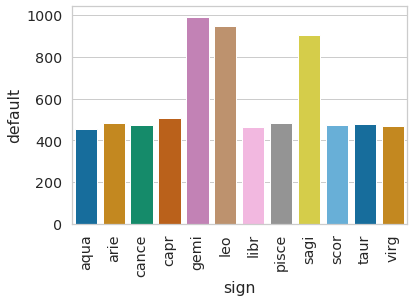

In [24]:
ax = sns.barplot(x='sign', y='default', data=df_train.groupby('sign').sum()['default'].reset_index(), 
                 palette='colorblind')
text = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

(-1000, 1000000)

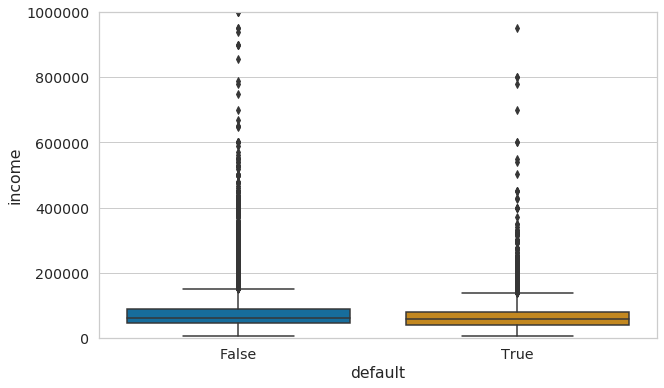

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax = sns.boxplot(x='default', y='income', data=df_train, palette='colorblind', ax=ax)
ax.set_ylim(-1000, 1000000)

In [44]:
df_train.groupby('default')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
False,50456.0,72344.158679,53074.475809,4821.18,45013.72,62023.365,87520.4150,5000027.83
True,9510.0,65922.677209,43229.193855,4835.29,41020.78,57021.045,80010.0075,950039.03


In [46]:
df_train[df_train['credit_limit'].isna()].isna().sum()

ids                       0
default                   0
score_1                   0
score_2                   0
score_3                   0
score_4                   0
score_5                   0
score_6                   0
risk_rate                 0
amount_borrowed           0
borrowed_in_months        0
credit_limit          18779
reason                    3
income                    0
sign                   5959
gender                  965
facebook_profile       1873
state                     0
zip                       0
channel                   0
job_name               1158
real_state                0
ok_since              12179
n_bankruptcies          202
n_defaulted_loans        18
n_accounts                0
n_issues              15580
dtype: int64

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report

In [105]:
na_count = df_train.isna().sum()
full_columns = na_count[na_count == 0].index
df_train_rf = df_train[full_columns]

categorical_columns = list(set(df_train_rf.select_dtypes('object').columns) - {'ids'})

In [106]:
df_train_rf[categorical_columns] = df_train_rf[categorical_columns].astype('category')
df_train_rf[categorical_columns] = df_train_rf[categorical_columns].apply(lambda x: x.cat.codes)

In [107]:
not_feat_columns = ['ids', 'default', 'channel']

In [108]:
X = df_train_rf[df_train_rf.columns.drop(not_feat_columns)]
y = df_train_rf['default']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [113]:
clf = RandomForestClassifier(max_depth=10, n_estimators=100)

In [114]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [118]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [121]:
pd.DataFrame(classification_report(y_train, train_pred, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.845352,0.995556,0.846056,0.920454,0.869173
recall,0.999975,0.029443,0.846056,0.514709,0.846056
f1-score,0.916185,0.057194,0.846056,0.486690,0.779956
support,40364.000000,7608.000000,0.846056,47972.000000,47972.000000


In [122]:
pd.DataFrame(classification_report(y_test, test_pred, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.841596,0.333333,0.841087,0.587465,0.760996
recall,0.999207,0.002103,0.841087,0.500655,0.841087
f1-score,0.913654,0.004180,0.841087,0.458917,0.769430
support,10092.000000,1902.000000,0.841087,11994.000000,11994.000000


In [125]:
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

borrowed_in_months    0.143707
score_1               0.124990
income                0.113450
amount_borrowed       0.086338
risk_rate             0.069629
score_5               0.067790
score_6               0.066566
score_4               0.061581
zip                   0.057475
score_3               0.055735
score_2               0.052836
n_accounts            0.043291
state                 0.040707
real_state            0.015904
dtype: float64